<a href="https://colab.research.google.com/github/tsubauaaa/LSTM_covid19_nominibatch_multivariate/blob/master/LSTM_covid19_nominibatch_multivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
# deviceの作成
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [3]:
device

'cuda'

In [4]:
# Google Driveをマウントする
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# PCR陽性者数データ
# 厚生労働省オープンデータを利用
# https://www.mhlw.go.jp/stf/covid-19/open-data.html
data1 = pd.read_csv('/content/drive/My Drive/pcr_positive_daily.csv')
# 東京都の平均気温データ
# 気象庁のデータを利用
# https://www.data.jma.go.jp/gmd/risk/obsdl/#
data2 = pd.read_csv('/content/drive/My Drive/covid19_temperature.csv')
# PCR検査実施人数データ
# 厚生労働省オープンデータを利用
# https://www.mhlw.go.jp/stf/covid-19/open-data.html
data3 = pd.read_csv('/content/drive/My Drive/pcr_tested_daily.csv').fillna(0)

In [6]:
# 3つのデータを結合する
data4 = pd.merge(data1,data2)
data = pd.merge(data4, data3)

In [7]:
print(data.columns)
print(data.shape)
print(data.head(5))
print(data.tail(5))

Index(['日付', 'PCR 検査陽性者数(単日)', '東京平均気温', 'PCR 検査実施件数(単日)'], dtype='object')
(320, 4)
          日付  PCR 検査陽性者数(単日)  東京平均気温  PCR 検査実施件数(単日)
0  2020/1/16               1     6.7             0.0
1  2020/1/17               0     7.3             0.0
2  2020/1/18               0     3.8             0.0
3  2020/1/19               0     6.5             0.0
4  2020/1/20               0     7.5             0.0
             日付  PCR 検査陽性者数(単日)  東京平均気温  PCR 検査実施件数(単日)
315  2020/11/26            2499    12.8         42634.0
316  2020/11/27            2510    11.6         43351.0
317  2020/11/28            2674    11.8         22307.0
318  2020/11/29            2041    10.1         11975.0
319  2020/11/30            1429     9.9         41335.0


In [8]:
len_data = data.shape[0]

In [9]:
covid19_data = data[['PCR 検査陽性者数(単日)', '東京平均気温', 'PCR 検査実施件数(単日)']]

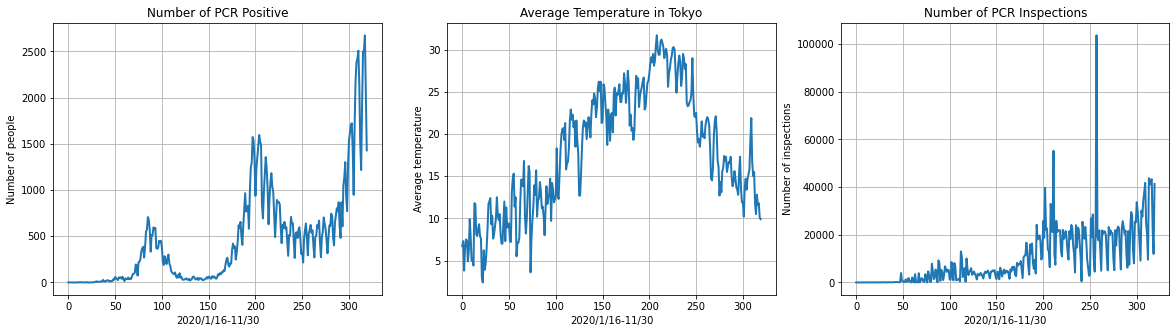

In [10]:
fig, (axL, axM, axR) = plt.subplots(ncols=3, figsize=(20,5))

axL.plot(covid19_data['PCR 検査陽性者数(単日)'], linewidth=2)
axL.set_title('Number of PCR Positive')
axL.set_xlabel('2020/1/16-11/30')
axL.set_ylabel('Number of people')
axL.grid(True)

axM.plot(covid19_data['東京平均気温'], linewidth=2)
axM.set_title('Average Temperature in Tokyo')
axM.set_xlabel('2020/1/16-11/30')
axM.set_ylabel('Average temperature')
axM.grid(True)

axR.plot(covid19_data['PCR 検査実施件数(単日)'], linewidth=2)
axR.set_title('Number of PCR Inspections')
axR.set_xlabel('2020/1/16-11/30')
axR.set_ylabel('Number of inspections')
axR.grid(True)

fig.show()

In [11]:
covid19_data = covid19_data.values.astype(float)

In [12]:
covid19_data.shape

(320, 3)

In [13]:
# 直近30日をテストデータにする
test_data_size = 30

train_data = covid19_data[:-test_data_size]
test_data = covid19_data[-test_data_size:]

In [14]:
print(len(train_data))
print(len(test_data))

290
30


In [15]:
# データセットの正規化を行う。最小値0と最大値1の範囲で行う。
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
train_data_normalized = scaler.fit_transform(train_data)

In [16]:
# (バッチ数, (陽性者数, 平均気温))
train_data_normalized.shape

(290, 3)

In [17]:
# Tensor型に変換する
train_data_normalized = torch.FloatTensor(train_data_normalized)

In [18]:
# シーケンスに沿ったデータを作成する関数
def make_sequence_data(input_data, num_sequence):
    # シーケンスデータとラベルデータの器
    data = []
    # 全体のデータ数取得
    num_data = len(input_data)
    # 全体からシーケンス分引いた数までループする
    for i in range(num_data - num_sequence):
        # 1個ずらして、シーケンス分のデータを取得していく
        seq_data = input_data[i:i+num_sequence]
        # シーケンスの次の要素のデータ(ラベルデータとして1個目の陽性者数のみ)を取得していく
        target_data = input_data[:,0][i+num_sequence:i+num_sequence+1]
        # シーケンスデータとラベルデータをタプルとして取得していく
        data.append((seq_data, target_data))

    return data

In [19]:
# シーケンス長は1ヶ月分30日とする
seq_length = 30
# train_seq_data=最初のデータを1個ずらしてシーケンス分のデータ(時系列の学習データ群)、train_target=train_seq_dataの次のデータ(ラベルデータ)
train_seq_data = make_sequence_data(train_data_normalized, seq_length)

In [20]:
# シーケンス分の1セットと正解データが260セットある
print(len(train_seq_data))

260


In [21]:
class LSTM(nn.Module):
    def __init__(self, input_size=3, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_layer_size, batch_first=True)

        self.linear = nn.Linear(in_features=hidden_layer_size, out_features=output_size)

    def forward(self, x):
        # LSTMのinputは(batch_size, seq_len, input_size)にする
        # LSTMのoutputは(batch_size, seq_len, hidden_layer_size)となる
        # hidden stateとcell stateにはNoneを渡して0ベクトルを渡す
        lstm_out, (hn, cn) = self.lstm(x, None)
        # Linearのinputは(N,∗,in_features)にする
        # lstm_out(batch_size, seq_len, hidden_layer_size)のseq_len方向の最後の値をLinearに入力する
        prediction = self.linear(lstm_out[:, -1, :])
        return prediction

In [22]:
model = LSTM()
model.to(device)

LSTM(
  (lstm): LSTM(3, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [23]:
# 損失関数と最適化関数を定義
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [24]:
epochs = 50
losses = []
for i in range(epochs):
    for seq, labels in train_seq_data:
        # seq, labelsのshapeは(seq_length, 特徴量)なのでLSTMに渡すために(batch, seq_length, 特徴量)にする。(batch=1)
        seq, labels = torch.unsqueeze(seq, 0), torch.unsqueeze(labels, 0)
        seq, labels = seq.to(device), labels.to(device)
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = criterion(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    losses.append(single_loss.item())
    print(f'epoch: {i}, loss : {single_loss.item()}')

epoch: 0, loss : 0.022945906966924667
epoch: 1, loss : 0.027851106598973274
epoch: 2, loss : 0.03396280109882355
epoch: 3, loss : 0.03367197513580322
epoch: 4, loss : 0.03040696121752262
epoch: 5, loss : 0.02713530883193016
epoch: 6, loss : 0.02363123744726181
epoch: 7, loss : 0.021050861105322838
epoch: 8, loss : 0.019197765737771988
epoch: 9, loss : 0.018096864223480225
epoch: 10, loss : 0.01751091331243515
epoch: 11, loss : 0.0174260213971138
epoch: 12, loss : 0.01743335649371147
epoch: 13, loss : 0.017717665061354637
epoch: 14, loss : 0.018184345215559006
epoch: 15, loss : 0.018480515107512474
epoch: 16, loss : 0.01810101792216301
epoch: 17, loss : 0.01821986399590969
epoch: 18, loss : 0.017464691773056984
epoch: 19, loss : 0.01720530353486538
epoch: 20, loss : 0.016689831390976906
epoch: 21, loss : 0.01677726022899151
epoch: 22, loss : 0.016729312017560005
epoch: 23, loss : 0.016213422641158104
epoch: 24, loss : 0.0159994475543499
epoch: 25, loss : 0.015470701269805431
epoch: 26, 

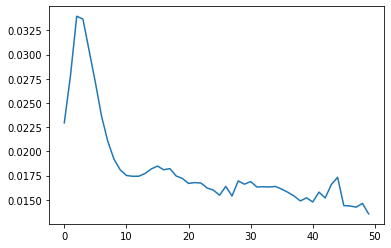

In [25]:
plt.plot(losses)

In [26]:
# # モデルパラメータを保存
# torch.save(model.state_dict(), './param.dict')

In [27]:
# # モデルパラメータをロード
# model.load_state_dict(torch.load('./param.dict'))

In [28]:
# 予測する日数
pred_days = 30
# テストデータの正規化を行う。最小値0と最大値1の範囲で行ってTensor型に変換する。
test_data_normalized = scaler.fit_transform(test_data)
test_data_normalized = torch.FloatTensor(test_data_normalized)
# 予測するためのデータの最初のseq_length分はtrain_dataを使う
test_inputs = train_data_normalized[-seq_length:].tolist()
print(test_inputs)

[[0.33667710423469543, 0.6348122954368591, 0.21084918081760406], [0.3536050021648407, 0.658703088760376, 0.13198812305927277], [0.2476489096879959, 0.6689419746398926, 0.04753269627690315], [0.16990596055984497, 0.658703088760376, 0.21089741587638855], [0.3115987479686737, 0.6348122954368591, 0.19710443913936615], [0.31661441922187805, 0.5426621437072754, 0.20642192661762238], [0.3899686634540558, 0.4197952151298523, 0.2063833475112915], [0.3724137842655182, 0.41296929121017456, 0.18998610973358154], [0.4194357395172119, 0.46416381001472473, 0.10419962555170059], [0.2708463966846466, 0.5938566327095032, 0.04896986857056618], [0.17115987837314606, 0.6518771052360535, 0.2241116613149643], [0.3097178637981415, 0.6723549365997314, 0.19124966859817505], [0.34420064091682434, 0.6109215021133423, 0.21062733232975006], [0.4407523572444916, 0.49146756529808044, 0.20001736283302307], [0.39811912178993225, 0.467576801776886, 0.19967012107372284], [0.36300939321517944, 0.351535826921463, 0.0954512

In [29]:
# モデルを評価モードとする
model.eval()
# 予測値を入れるリスト
test_outputs = []
for i in range(pred_days):
    seq = torch.FloatTensor(test_inputs[-seq_length:])
    seq = torch.unsqueeze(seq, 0)
    seq = seq.to(device)
    with torch.no_grad():
        test_inputs.append(test_data_normalized.tolist()[i])
        test_outputs.append(model(seq).item())

In [30]:
print(len(test_outputs))

30


In [31]:
np_test_outputs = np.array(test_outputs).reshape(-1,1)
# 列方向に同じ値を追加して(30, 3)にする
np_test_outputs2 = np.hstack((np_test_outputs, np_test_outputs))
np_test_outputs3 = np.hstack((np_test_outputs2, np_test_outputs))
actual_predictions = scaler.inverse_transform(np_test_outputs3)

In [32]:
x = np.arange(len_data-pred_days, len_data, 1)
print(x)

[290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307
 308 309 310 311 312 313 314 315 316 317 318 319]


In [33]:
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 10
fig_size[1] = 5
plt.rcParams['figure.figsize'] = fig_size

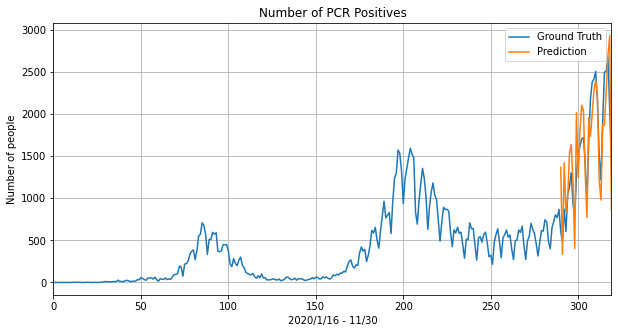

In [34]:
plt.title('Number of PCR Positives')
plt.ylabel('Number of people')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(data['PCR 検査陽性者数(単日)'], label='Ground Truth')
plt.plot(x, actual_predictions[:,0], label='Prediction')
plt.xlabel('2020/1/16 - 11/30')
plt.legend()
plt.show()

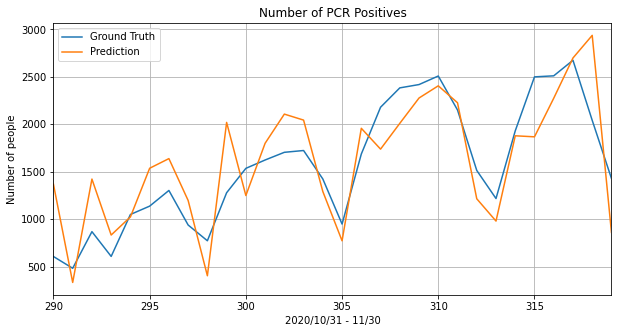

In [35]:
plt.title('Number of PCR Positives')
plt.ylabel('Number of people')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(x, data['PCR 検査陽性者数(単日)'][-1*pred_days:], label='Ground Truth')
plt.plot(x, actual_predictions[:,0], label='Prediction')
plt.xlabel('2020/10/31 - 11/30')
plt.legend()
plt.show()